In [36]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn import datasets

In [37]:
use_cuda = torch.cuda.is_available()

In [38]:
device = torch.device('cuda') if use_cuda else "cpu"

In [39]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 32)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(32, 8)
        self.relu2 = nn.ReLU()
        self.out = nn.Linear(8, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.relu2(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y

In [40]:
def train_epoch(model, opt, criterion, batch_size, X_data, Y_data, mode="train"):
    
    if(mode == "train"):
        model.train()
    else:
        model.eval()
    
    losses = []
    running_corrects = 0
    shuffled_idx = list(np.random.permutation(X_data.size()[0]))
    X_data_shuffled = [X_data[i] for i in shuffled_idx]
    Y_data_shuffled = [Y_data[i] for i in shuffled_idx]
    minibatch_idxs = np.array_split(shuffled_idx, len(shuffled_idx)/batch_size)
    for minibatch_ids in minibatch_idxs:
        x_batch = X_data[minibatch_ids]
        y_batch = Y_data[minibatch_ids]
        x_batch = Variable(x_batch).to(device)
        y_batch = Variable(y_batch).to(device)
        opt.zero_grad()
        
        if(mode == "train"):
            y_hat = model(x_batch)
        else:
            with torch.no_grad():
                y_hat = model(x_batch)
        
        y_preds = (y_hat > 0.5).type(torch.float32)
        loss = criterion(y_hat, y_batch)
        
        corrects = float(torch.sum(y_preds == y_batch).item())
        running_corrects += corrects
        
        if(mode == "train"):
            loss.backward()
            opt.step()
            
        losses.append(loss.item())
        
    accuracy = running_corrects * 1.0 / len(shuffled_idx)
    avg_loss = sum(losses) * 1.0 / len(losses)
    return avg_loss, accuracy

### CIrcular data

In [41]:
X, Y = datasets.make_circles(n_samples=25000, factor=.6, noise=.1)

In [42]:
X_train = torch.tensor(X[0:20000], dtype = torch.float32)
X_valid = torch.tensor(X[20000:], dtype = torch.float32)
Y_train = torch.tensor(Y[0:20000], dtype = torch.float32)
Y_valid = torch.tensor(Y[20000:], dtype = torch.float32)

Y_train = Y_train.view(Y_train.size()[0], 1)
Y_valid = Y_valid.view(Y_valid.size()[0], 1)
one_indices = np.where(Y==1)
zero_indices = np.where(Y==0)

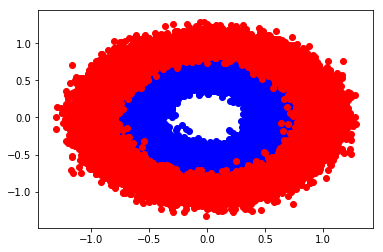

In [43]:
plt.scatter(X[one_indices, 0], X[one_indices, 1], color='b')
plt.scatter(X[zero_indices, 0], X[zero_indices, 1], color='r')

In [54]:
net = Net().to(device)
opt = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999))
batch_size = 32
num_epochs = 30
criterion = nn.BCELoss()

In [55]:
train_loss_seq = []
val_loss_seq = []
train_acc_seq = []
val_acc_seq = []
for e in range(num_epochs):
    print("================ EPOCH", e, "/", num_epochs)
    train_loss, train_acc = train_epoch(net, opt, criterion, batch_size, X_train, Y_train, "train")
    val_loss, val_acc = train_epoch(net, opt, criterion, batch_size, X_valid, Y_valid, "validation")
    train_loss_seq.append(train_loss)
    train_acc_seq.append(train_acc)
    val_loss_seq.append(val_loss)
    val_acc_seq.append(val_acc)
    print("Train loss and accuracy: ", train_loss, train_acc)
    print("Val loss and accuracy: ", val_loss, val_acc)

================ EPOCH 0 / 30
Train loss and accuracy:  0.6905561191558838 0.52055
Val loss and accuracy:  0.6777279690290109 0.685
================ EPOCH 1 / 30
Train loss and accuracy:  0.6642487961769103 0.6956
Val loss and accuracy:  0.638481698739223 0.9464
================ EPOCH 2 / 30
Train loss and accuracy:  0.6221978691101074 0.78625
Val loss and accuracy:  0.587853349172152 0.9018
================ EPOCH 3 / 30
Train loss and accuracy:  0.5727961171150208 0.81485
Val loss and accuracy:  0.5301969823164817 0.9396
================ EPOCH 4 / 30
Train loss and accuracy:  0.5244629241943359 0.8357
Val loss and accuracy:  0.47250849791826344 0.9516
================ EPOCH 5 / 30
Train loss and accuracy:  0.47659034276008605 0.8528
Val loss and accuracy:  0.4166829641430806 0.9636
================ EPOCH 6 / 30
Train loss and accuracy:  0.43861667275428773 0.8582
Val loss and accuracy:  0.36863918869923323 0.9666
================ EPOCH 7 / 30
Train loss and accuracy:  0.40246282491683

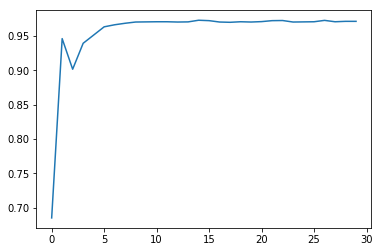

In [60]:
plt.plot(val_acc_seq)